In [3]:
! pip install optuna --quiet

     |████████████████████████████████| 348 kB 14.5 MB/s 
     |████████████████████████████████| 209 kB 72.5 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 69.3 MB/s 
     |████████████████████████████████| 147 kB 75.6 MB/s 


In [4]:
import torch
import optuna
import numpy as np
import matplotlib.pylab as plt
from IPython.display import clear_output
import torch.nn as nn 
import torch.optim as optim

import antidistil
import pipeline
import consts
from importlib import reload
import plot
import json
reload(plot)
reload(antidistil)
reload(pipeline)
reload(consts)
plot.prepare_for_plots()

Using cuda device
Using cuda device


<Figure size 864x720 with 0 Axes>

In [5]:
train_dataloader, test_dataloader = pipeline.get_data()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [15]:
def train_antidistill_loop(l1, l2, l3):

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for i in range(consts.num_repeats):
        clear_output()
        print(f"Model {i+1}\n-------------------------------"
                          "\n-------------------------------")

        torch.manual_seed(i)

        teacher = pipeline.make_teacher_model()
        teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_5cl_{i}.pt'))
        model = antidistil.make_student_model()

        mask = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.float).to(consts.device)
        
        loss_fn = antidistil.altidistill_loss
        optimizer = optim.Adam(model.parameters(), lr=consts.student_5_antidistil_learning_rate)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

        lambdas = [l1, l2, l3, 0]
        
        for epoch in range(10):
            print(f"Epoch {epoch+1}\n-------------------------------")

            pipeline.antidistil_loop(teacher, model, lambdas, mask, train_dataloader, 
                                    loss_fn, optimizer, scheduler, noise_dist='uniform', noise_eps=1e-1)

        optimizer = optim.Adam(model.parameters(), lr=consts.student_5_learning_rate)    

        mask = torch.ones(10).to(consts.device)

        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(10):
            print(f"Epoch {epoch+1}\n-------------------------------")

            pipeline.train_loop(model, history, mask, train_dataloader, loss_fn, optimizer)
            pipeline.test_loop(model, history, mask, test_dataloader, loss_fn)

        pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
        pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)

    return np.array(history['fsgm_noise_acc']).mean(axis=0)[-1]

In [16]:
def objective(trial):
    l1 = trial.suggest_float('l1', 0, 1)
    l2 = trial.suggest_float('l2', 0, 1)
    l3 = trial.suggest_float('l3', 0, 1)
    
    acc = train_antidistill_loop(l1, l2, l3)

    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

Model 10
-------------------------------
-------------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1
-------------------------------


Train Loss: 22.865306764967897
Train Acc: 0.8801333333333333
Epoch 2
-------------------------------


Train Loss: 2.8469566554465193
Train Acc: 0.9446
Epoch 3
-------------------------------


Train Loss: 0.10992031171917915
Train Acc: 0.9477
Epoch 4
-------------------------------


Train Loss: 0.05736883197059023
Train Acc: 0.9483666666666667
Epoch 5
-------------------------------


Train Loss: 0.05062027481642175
Train Acc: 0.9489
Epoch 6
-------------------------------


Train Loss: 0.047068417151557636
Train Acc: 0.9498
Epoch 7
-------------------------------


Train Loss: 0.04446928661237372
Train Acc: 0.9500333333333333
Epoch 8
-------------------------------


Train Loss: 0.043404753989678746
Train Acc: 0.9502
Epoch 9
-------------------------------


Train Loss: 0.04090768105172096
Train Acc: 0.9511
Epoch 10
-------------------------------


Train Loss: 0.03979387574214885
Train Acc: 0.9511333333333334
Epoch 1
-------------------------------


Validation accuracy: 83.4%, Validation loss: 0.466445 

Epoch 2
-------------------------------


Validation accuracy: 85.6%, Validation loss: 0.399004 

Epoch 3
-------------------------------


Validation accuracy: 86.7%, Validation loss: 0.372471 

Epoch 4
-------------------------------


Validation accuracy: 87.4%, Validation loss: 0.362186 

Epoch 5
-------------------------------


Validation accuracy: 87.6%, Validation loss: 0.356232 

Epoch 6
-------------------------------


Validation accuracy: 87.7%, Validation loss: 0.350975 

Epoch 7
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.351380 

Epoch 8
-------------------------------


Validation accuracy: 87.7%, Validation loss: 0.353753 

Epoch 9
-------------------------------


Validation accuracy: 88.2%, Validation loss: 0.351398 

Epoch 10
-------------------------------


Validation accuracy: 88.4%, Validation loss: 0.348451 



FSGM Accuracy [0.8838, 0.8532, 0.8234, 0.7924, 0.7564, 0.7207, 0.6856, 0.6519, 0.6138, 0.5765]


[I 2022-10-17 13:18:30,588] Trial 4 finished with value: 0.5667500000000001 and parameters: {'l1': 0.1762690332438911, 'l2': 0.48422887495762634, 'l3': 0.08298194407722581}. Best is trial 2 with value: 0.57191.


Noise Accuracy [0.8838, 0.8811, 0.8752, 0.863, 0.8504, 0.838, 0.7978, 0.7689, 0.7384, 0.6918]


In [17]:
study.best_trials

[FrozenTrial(number=2, values=[0.57191], datetime_start=datetime.datetime(2022, 10, 17, 11, 44, 27, 472483), datetime_complete=datetime.datetime(2022, 10, 17, 12, 15, 53, 477131), params={'l1': 0.5794205651168035, 'l2': 0.9948911593161102, 'l3': 0.4977024067547632}, distributions={'l1': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'l2': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'l3': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)]

In [18]:
optuna.importance.get_param_importances(study)

OrderedDict([('l1', 0.39833571937069295),
             ('l3', 0.3802390944763488),
             ('l2', 0.22142518615295828)])

In [19]:
l1 = 0.5794205651168035
l2 = 0.9948911593161102
l3 = 0.4977024067547632

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(consts.num_repeats):
    clear_output()
    print(f"Model {i+1}\n-------------------------------"
                      "\n-------------------------------")

    torch.manual_seed(i)

    teacher = pipeline.make_teacher_model()
    teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_5cl_{i}.pt'))
    model = antidistil.make_student_model()

    mask = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.float).to(consts.device)
    
    loss_fn = antidistil.altidistill_loss
    optimizer = optim.Adam(model.parameters(), lr=consts.student_5_antidistil_learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

    lambdas = [l1, l2, l3, 0]
    
    for epoch in range(consts.student_5_antidistil_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        pipeline.antidistil_loop(teacher, model, lambdas, mask, train_dataloader, 
                                loss_fn, optimizer, scheduler, noise_dist='uniform', noise_eps=1e-1)

    optimizer = optim.Adam(model.parameters(), lr=consts.student_5_learning_rate)    

    mask = torch.ones(10).to(consts.device)

    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(consts.student_5_training_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        pipeline.train_loop(model, history, mask, train_dataloader, loss_fn, optimizer)
        pipeline.test_loop(model, history, mask, test_dataloader, loss_fn)

    pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
    pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)

Model 10
-------------------------------
-------------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1
-------------------------------


Train Loss: 47.367622955809246
Train Acc: 0.8791333333333333
Epoch 2
-------------------------------


Train Loss: 5.983085723126188
Train Acc: 0.9443333333333334
Epoch 3
-------------------------------


Train Loss: 0.32152466209644964
Train Acc: 0.9477
Epoch 4
-------------------------------


Train Loss: 0.2038004937641164
Train Acc: 0.9495333333333333
Epoch 5
-------------------------------


Train Loss: 0.18796481984726926
Train Acc: 0.9501333333333334
Epoch 6
-------------------------------


Train Loss: 0.17761701351784645
Train Acc: 0.9504333333333334
Epoch 7
-------------------------------


Train Loss: 0.17001262801758787
Train Acc: 0.9509666666666666
Epoch 8
-------------------------------


Train Loss: 0.1658928705339736
Train Acc: 0.9509333333333333
Epoch 9
-------------------------------


Train Loss: 0.1606421672600381
Train Acc: 0.9515333333333333
Epoch 10
-------------------------------


Train Loss: 0.15558431050244798
Train Acc: 0.9517666666666666
Epoch 11
-------------------------------


Train Loss: 0.15130847641762266
Train Acc: 0.9515666666666667
Epoch 12
-------------------------------


Train Loss: 0.14686374397988014
Train Acc: 0.9521
Epoch 13
-------------------------------


Train Loss: 0.14391127307998372
Train Acc: 0.9526333333333333
Epoch 14
-------------------------------


Train Loss: 0.14089690453194556
Train Acc: 0.9534333333333334
Epoch 15
-------------------------------


Train Loss: 0.1400043472330621
Train Acc: 0.9533666666666667
Epoch 1
-------------------------------


Validation accuracy: 83.4%, Validation loss: 0.462032 

Epoch 2
-------------------------------


Validation accuracy: 85.5%, Validation loss: 0.402898 

Epoch 3
-------------------------------


Validation accuracy: 86.5%, Validation loss: 0.378739 

Epoch 4
-------------------------------


Validation accuracy: 87.0%, Validation loss: 0.367273 

Epoch 5
-------------------------------


Validation accuracy: 87.2%, Validation loss: 0.363328 

Epoch 6
-------------------------------


Validation accuracy: 87.3%, Validation loss: 0.364322 

Epoch 7
-------------------------------


Validation accuracy: 87.6%, Validation loss: 0.360853 

Epoch 8
-------------------------------


Validation accuracy: 87.7%, Validation loss: 0.360942 

Epoch 9
-------------------------------


Validation accuracy: 87.7%, Validation loss: 0.361087 

Epoch 10
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.362643 

Epoch 11
-------------------------------


Validation accuracy: 87.9%, Validation loss: 0.362636 

Epoch 12
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.369402 

Epoch 13
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.375364 

Epoch 14
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.381013 

Epoch 15
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.382822 

Epoch 16
-------------------------------


Validation accuracy: 87.9%, Validation loss: 0.395778 

Epoch 17
-------------------------------


Validation accuracy: 87.9%, Validation loss: 0.402702 

Epoch 18
-------------------------------


Validation accuracy: 87.9%, Validation loss: 0.405499 

Epoch 19
-------------------------------


Validation accuracy: 87.9%, Validation loss: 0.411161 

Epoch 20
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.415241 

Epoch 21
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.425105 

Epoch 22
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.431375 

Epoch 23
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.435922 

Epoch 24
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.445019 

Epoch 25
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.451612 

Epoch 26
-------------------------------


Validation accuracy: 88.1%, Validation loss: 0.470789 

Epoch 27
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.468398 

Epoch 28
-------------------------------


Validation accuracy: 87.9%, Validation loss: 0.497744 

Epoch 29
-------------------------------


Validation accuracy: 87.8%, Validation loss: 0.499523 

Epoch 30
-------------------------------


Validation accuracy: 88.0%, Validation loss: 0.508286 



FSGM Accuracy [0.8801, 0.8431, 0.8018, 0.7616, 0.7239, 0.6855, 0.6486, 0.6096, 0.5766, 0.5448]


Noise Accuracy [0.8801, 0.8782, 0.8728, 0.8633, 0.8518, 0.8441, 0.8228, 0.7946, 0.7671, 0.7541]


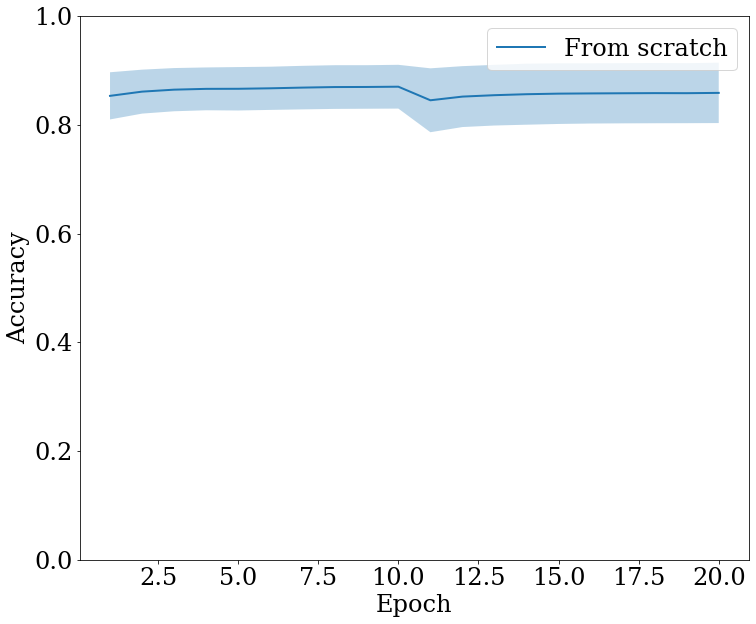

In [20]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], np.arange(1, consts.student_5_training_epochs + 1),
                   ['From scratch'], 'val_acc', 
                    'Epoch', 'Accuracy')

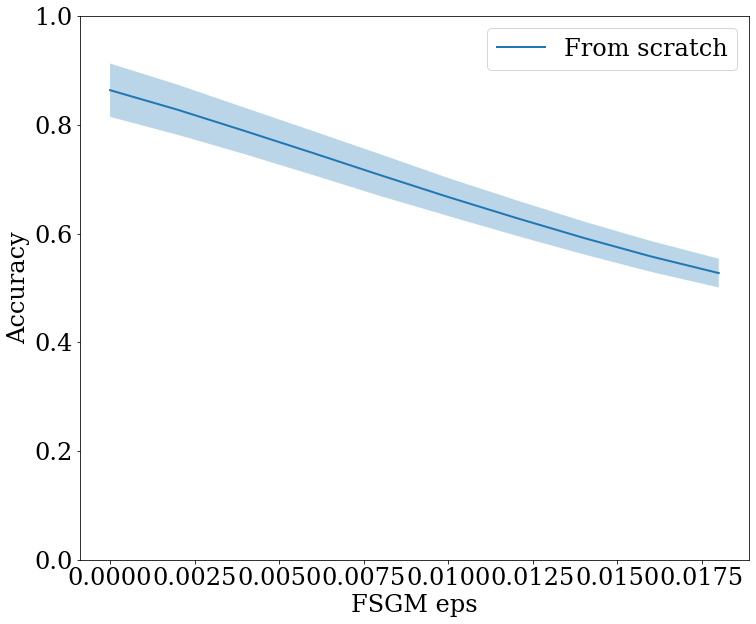

In [21]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'fsgm_noise_acc', 
                    'FSGM eps', 'Accuracy')

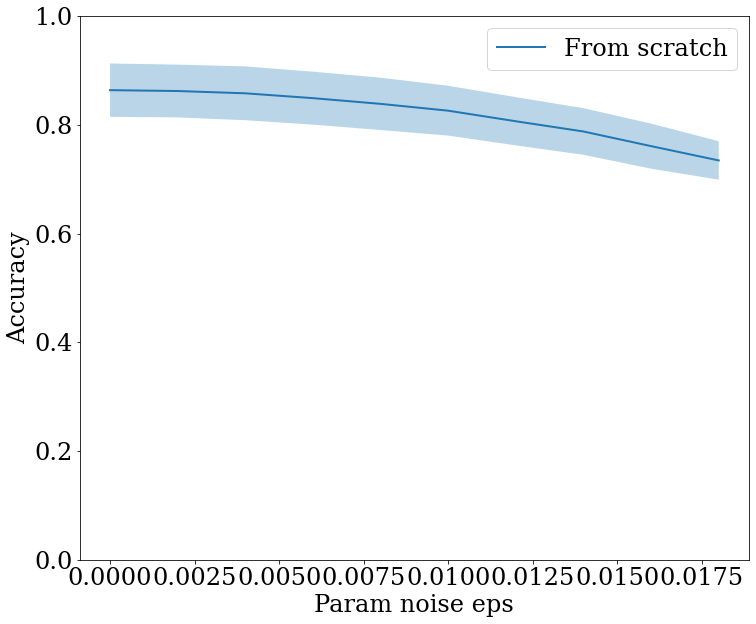

In [22]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'param_noise_acc', 
                    'Param noise eps', 'Accuracy')

In [23]:
with open(pipeline.get_path()+'/history_best_antidistill.json', 'w') as out:
    out.write(json.dumps(history))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
